In [88]:
#%reset
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
S0 = 100 # Initial Stock Price
alpha0 = 0.1
alpha1,beta1 = 0.2,0.4# drift
risk_lambda = 0.005
r = 0.03 #risk-free rate
M = 1 # maturity
T =24 #Number of time steps
N_MC = 2000000#Number of Mont Carlo Pathes
delta_t = M/T
gamma = np.exp(-r *delta_t) # discount factor
h0 = 0.01
epslion0 = 0
K = 100
mu = 0.05 


Time Cost for simulating 100000 pathes: 60.76981997489929 seconds


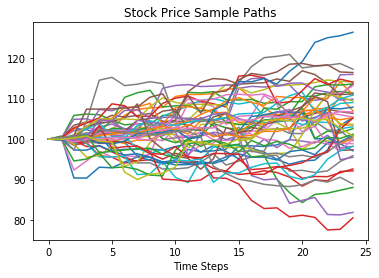

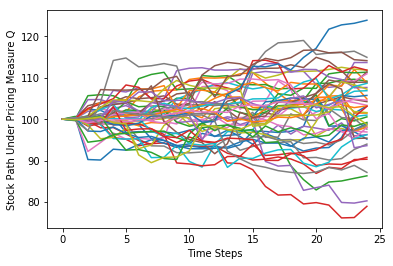

In [89]:
starttime = time.time()
np.random.seed(42)
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0
h = pd.DataFrame([],index = range(1,N_MC+1), columns = range(T))
h.loc[:,0] = h0
SIGMA = pd.DataFrame([], index = range(1,N_MC+1), columns = range(T))
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(T))
SIGMA.loc[:,0] = h.loc[:,0]*RN.loc[:,0]
X = pd.DataFrame([],index = range(1,N_MC+1),columns = range(T+1))
X.loc[:,0] = S0
delta_W = pd.DataFrame(np.random.randn(N_MC,T)*np.sqrt(delta_t), index=range(1, N_MC+1), columns=range(T))

for t in range(1,T+1):
    S.loc[:,t] = S.loc[:,t-1] + S.loc[:,t-1]*(mu*delta_t + SIGMA.loc[:,t-1]*delta_W.loc[:,t-1])
    X.loc[:,t] = X.loc[:,t-1] + X.loc[:,t-1]* ( r*delta_t + SIGMA.loc[:,t-1]*delta_W.loc[:,t-1])
    if t<=T-1:
        h.loc[:,t] = alpha0 + beta1 * h.loc[:,t-1]**2 + alpha1* SIGMA.loc[:,t-1]**2
        SIGMA.loc[:,t] = h.loc[:,t]*RN.loc[:,t]

endtime = time.time()
print('\nTime Cost for simulating 100000 pathes:', endtime - starttime, 'seconds')

step_size = N_MC // 50
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot]) # plot(S', idx_plot:MC) Plot 1000....9000 10 pathes
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('Stock Path Under Pricing Measure Q')
plt.show()


In [90]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K-ST, 0)
    return payoff

In [91]:
discounted_pay_off = ( X.iloc[:,-1].apply(lambda x: terminal_payoff(x, K)) ) * np.exp(-r*1)
print( 'Price at time 0 is : '+str(np.mean(discounted_pay_off) ) )

np.mean(discounted_pay_off) - 1.96* np.std(discounted_pay_off)/np.sqrt(N_MC)

Price at time 0 is : 2.7516188112690005


2.745008567778391

Number of points k =  17


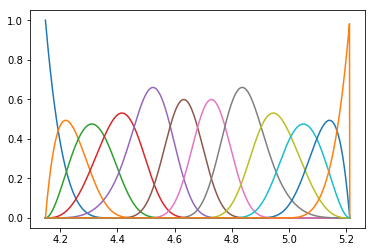

num_basis =  12
dim data_mat_t =  (25, 50000, 12)
Computational time: 298.6986789703369 seconds


In [63]:
X = np.log(S) ## State Variable for Q-Learning
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12
tau = np.linspace(X_min,X_max,ncolloc)  # knotes
# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p

k = splinelab.aptknt(tau, p) #Question: Is 12 knotes enough? 
basis = bspline.Bspline(k, p) #B_{ik}       
f = plt.figure()

print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600) # 12 basis

#\phi_{n}(X_{t}^{k}) dimension:(num_t * num_mc* num_basis)
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

# fill it, expand function in finite dimensional space
# in neural network the basis is the neural network itself
t_0 = time.time()
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')




Time Cost: 2.3120839595794678 seconds


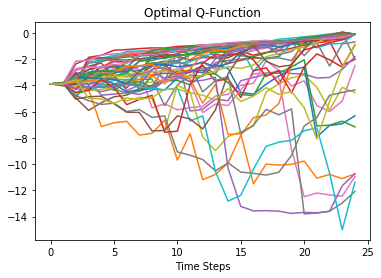

In [78]:

def function_A_vec(t, delta_S_hat, data_mat, reg_param):

    A_mat = np.zeros((num_basis, num_basis))
    for n in range(num_basis):
        for m in range(num_basis):
            A_mat[n,m] = np.sum(np.multiply( np.multiply(data_mat[t,:,n],data_mat[t,:,m]), delta_S_hat.iloc[:,t]**2 ))
            
    s = A_mat.shape
    A_mat += np.eye(s[0],s[1])*reg_param
    #A_mat = (A_mat - np.min(A_mat))/ (np.max(A_mat) - np.min(A_mat)) # rescale [0,1]
    return A_mat
    
        
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat=delta_S_hat, 
                   S=S, 
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    
    coef = risk_lambda*1.0/(2 * gamma ) # override it by zero to have pure risk hedge
    
    delta_S = S.loc[:,1:T].values - np.exp(r*delta_t)*S.loc[:,0:T-1]
    B_vec = np.ones((num_basis,1))
    for n in range(num_basis):
        first_part = np.multiply( np.multiply(data_mat[t,:,n],Pi_hat.iloc[:,t+1]), delta_S_hat.iloc[:,t] )
        second_part = np.sum(np.multiply(data_mat[t,:,n],delta_S.iloc[:,t]))*coef
        B_vec[n] = np.sum(first_part)+second_part
        
    #B_vec = (B_vec - np.min(B_vec))/ (np.max(B_vec) - np.min(B_vec))
    return B_vec

starttime = time.time()


Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t,gamma, risk_lambda)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
starttime = time.time()
# reward function
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) #R(N_mc, t)
R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1])

for t in range(T):
    R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t])

def function_C_vec(t, data_mat, reg_param):
    C_mat = np.zeros((num_basis,num_basis))
    for n in range(num_basis):
        for m in range(num_basis):
            C_mat[n,m] = np.sum( np.multiply(data_mat[t,:,n],data_mat[t,:,m]) )
    S = C_mat.shape
    C_mat += np.eye(S[0],S[1]) *reg_param

    return C_mat
   
def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    D_vec = np.zeros((num_basis,1))
    for n in range(num_basis):
        D_vec[n] =np.sum( np.multiply(data_mat[t,:,n],R.iloc[:,t]) ) + np.sum(np.multiply(data_mat[t,:,n],gamma*Q.iloc[:,t+1]))
    return D_vec

starttime = time.time()

Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

reg_param = 1e-3
for t in range(T-1, -1, -1):
   
    C_mat = function_C_vec(t,data_mat_t,reg_param) #R has been computed for optimal actions
    D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec)
    Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega) # Update Q for the next loop. 
step_size = N_MC // 50
idx_plot = np.arange(step_size, N_MC, step_size)    
Q = Q.astype('float')
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
plt.plot(Q.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Q-Function')
plt.savefig('DPwith100steps.png', dpi=600) # 12 basis
plt.show()

In [79]:
print(np.mean(Q.T.iloc[0,:]))

-3.881511503684916


In [80]:
eta = 0.3
np.random.seed(42)

a_op = pd.DataFrame([],index=range(1,N_MC+1),columns=range(T+1))
a_op.iloc[:,-1] = 0
a_op.iloc[:,-1] = 0
Pi_op = pd.DataFrame([],index=range(1,N_MC+1),columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x,K))

Pi_op_hat = pd.DataFrame([], index=range(1,N_MC+1),columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])
R_op = pd.DataFrame([],index=range(1,N_MC+1),columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

for t in range(T-1,-1,-1):
    a_op.iloc[:,t] = a.iloc[:,t].values*np.random.uniform(low=1-eta, high=1+eta, size=(N_MC,))
    Pi_op.iloc[:,t] = gamma*Pi_op.iloc[:,t+1] - gamma*a_op.iloc[:,t]*delta_S.iloc[:,t]
    R_op.iloc[:,t] = gamma*a.iloc[:,t]*delta_S.iloc[:,t] - risk_lambda*np.var(Pi_op.iloc[:,t])
    Pi_op_hat.iloc[:,t] = Pi_op.iloc[:,t] - np.mean(Pi_op.iloc[:,t])
    
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy() 
R = R_op.copy()    


num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS)) # [1,at,0.5at^2] reshape(1) only for constructing 3D array

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

print(A_stack.shape)


data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

A_2 = np.expand_dims(A_stack, axis=1) #Insert axis means to acturally spand matrix at that axis position which push the axis that you want to spand backward.
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  #Expand cross Montelarlo become four dimensions matrices
Psi_mat = np.multiply(A_2, data_mat_swap_idx) 
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

Psi_1_aux = np.expand_dims(Psi_mat, axis=1) 
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) # Sum over MC. 
print(Psi_mat.shape) 


del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2
print(S_t_mat.shape)

(3, 50000, 25)
(36, 50000, 25)
(36, 36, 25)


(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)

Time Cost: 14.237549066543579 seconds


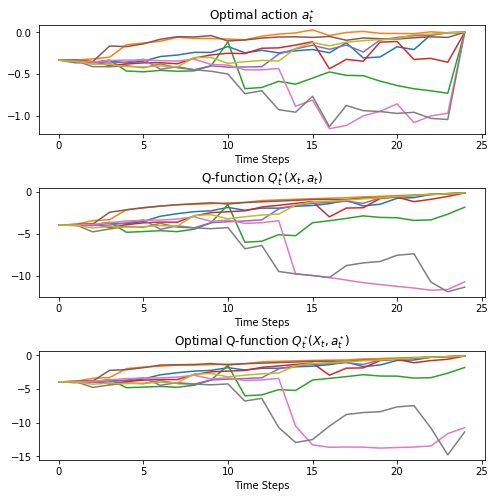

In [81]:
def function_S_vec(t, S_t_mat, reg_param):
    """
    function_S_vec - calculate S_{nm} matrix from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t - time index, a scalar, an index into time axis of S_t_mat 
    S_t_mat - pandas.DataFrame of dimension num_Qbasis x num_Qbasis x T
    reg_param - regularization parameter, a scalar
    Return:
    S_mat_reg - num_Qbasis x num_Qbasis
    """
    S_mat_reg = S_t_mat[:,:,t] + np.eye(3*num_basis,3*num_basis)

    return S_mat_reg
   
def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, 
                   gamma=gamma):
    """
    function_S_vec - calculate M_{nm} vector from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t- time index, a scalar, an index into time axis of S_t_mat 
    Q_star - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    Psi_mat_t - pandas.DataFrame of dimension num_Qbasis x N_MC
    gamma - one time-step discount factor $exp(-r \delta t)$
    Return:
    M_t - np.array of dimension num_Qbasis x 1
    """
    P_span= np.expand_dims(Psi_mat_t, axis=0)
    R1 = np.expand_dims(R.iloc[:,t].values,axis=0)
    R2 = np.expand_dims(R1,axis=1)
    Q1 = np.expand_dims(Q_star.iloc[:,t+1].values,axis=0)
    Q2 = np.expand_dims(Q1,axis=1)
    
    M = np.multiply(P_span,R2)+ gamma*np.multiply(P_span,Q2)

    M_t = np.sum(M[0,:,:],axis=1)
   


    return M_t



starttime = time.time()

Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])


a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0


Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

hyper_param =  1e-1

for t in range(T-1, -1, -1):
    
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)
    
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    print(phi.shape)
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)[:,0]
    a_star.loc[:,t] = a_opt[:,t] 

    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
        
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    
    Psi_t = Psi_mat[:,:,t].T  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
    
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')



f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()

In [82]:
np.mean(Q_RL.T.iloc[0, :]) # Risk-lambda 0.01: mean-5.01. std: 0.0013139654958257755
                        # Risk Lambda 0.001. Mean -2.993 std 0.0007809554516617878
                        # Risk Lambda 0.0001. mEAN -2.7617. std 0.0007219520532299768
                        # Risk Lambda 0.005. Mean -3.9299. std: 0.0010185.



-3.929918039500581

In [85]:
#np.std(Q_RL.T.iloc[0, :]) 

5.01- 1.96* (0.0013139654958257755/np.sqrt(N_MC))

5.009988482584618

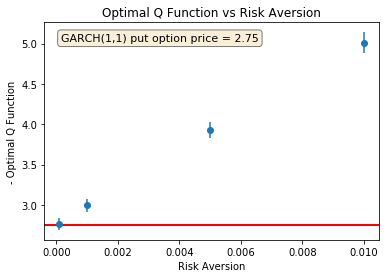

In [102]:
lam_vals = np.array([0.0001, 0.001, 0.005, 0.01])
# Q_vals =  np.array([3.77, 3.81, 4.57, 7.967,12.2051])
Q_vals =  np.array([2.7617, 2.993, 3.9299, 5.01])
Q_std =  np.array([0.0007219520532299768,0.0007809554516617878, 
                   0.0010185, 0.0013139654958257755])*100

BS_price = 2.75161
# f, axarr = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(4.0)
f.set_figwidth(4.0)
# ax.plot(lam_vals,Q_vals) 
ax.errorbar(lam_vals, Q_vals, yerr=Q_std, fmt='o')
ax.set_xlabel('Risk Aversion')
ax.set_ylabel('- Optimal Q Function')
ax.set_title(r'Optimal Q Function vs Risk Aversion')
ax.axhline(y=BS_price,linewidth=2, color='r')
textstr = 'GARCH(1,1) put option price = %2.2f'% (BS_price)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
plt.savefig('Opt_price_vs_lambda_Markowitz.png')
plt.show()

In [1]:
2.7516188112690005-2.745008567778391

0.00661024349060968

In [2]:
0.00661024349060968+2.7516188112690005

2.75822905475961